# Classification 

In [1]:
# Import some helper functions (please ignore this!)
from utils import * 

**Context:** We've just learned the framework underlying predictive models---their directed graphical model and MLE objective. We've instantiated this framework for regression---the task of predicting *real-valued* outputs from inputs. Now, we will provide another instantiation: classification. Classification focuses on predicting *categorical-valued* outputs from inputs. For example, given chest X-rays, we may want to predict whether a patient has COVID or not; given a sample of text, we may want to predict whether it has positive or negative sentiment; given a patient's demographic information, we may want to predict whether medication will be helpful, unhelpful, or harmful. 

**Challenge:** A classification model is a specific instance of a predictive model; as such, you may find it useful to review the unit on regression before continuing. After reviewing, you'll notice that the main piece that differentiates different types of predictive models is the choice of conditional. That is, if our goal is to predict $Y$ from $X$, we need to define $p_{Y | X}$. Whereas for regression, we used a real-valued distribution---a Gaussian---here we will use a Bernoulli or Categorical distribution.

**Outline:**
* Instantiate classification models
* Implement classification models in `NumPyro`
* Interpret a classifier fit on IHH data

**Data:** You're continuing your collaboration with your colleagues at the IHH's Center for Telekinesis Research. This time, the researchers are interested in developing a tool that can help patients make informed treatment decisions. Specifically, there is a large segment of your patient population that suffers from a lack of telekinetic control; that is, their telekinetic abilities tend to do something unexpected---when trying to move a bookshelf to the right, it moves forward, when trying to lift a mug, the mug lifts but spills on the floor, etc. Fortunately, there's a new medication that was just developed that's designed to help patients regain control of their telekinetic abilities. The problem with the medication is that it has some negative side effects (nausea, headaches), so it's important that patients getting the medication can weigh the risks against the benefits. Your colleagues therefore asked you to build a predictive model to determine what the effects of the medication will be. This predictive model will be given to clinicians so they can communicate with patients how likely they are to recover their telekinetic control. 

You just got sent the data and are eager to take a peak. Your colleagues are most excited about understanding the relationship between age, the dosage of medication, and telekinetic control. As you see below, the data includes two columns relating to control. `Control-Before` represents whether the patients had telekinetic control before receiving the medication, and `Control-After` represents the effect of the medication. 

In [79]:
# Import a bunch of libraries we'll be using below
import pandas as pd
import matplotlib.pylab as plt
import numpyro
import numpyro.distributions as D
import jax
import jax.numpy as jnp

# Load the data into a pandas dataframe
csv_fname = 'data/IHH-CTR-CGLF-classification.csv'
data = pd.read_csv(csv_fname, index_col='Patient ID')

# Print a random sample of patients, just to see what's in the data
data.sample(15, random_state=0)

,Age,Dose,Glow,Telekinetic-Ability,Control-Before,Control-After
Patient ID,,,,,,
405,17.600859,0.764120,0.868124,0.294490,1,1
1190,5.332611,0.944742,0.941606,0.404568,1,1
1132,35.766937,0.796327,0.605670,-0.053640,0,1
731,33.879105,0.802059,0.605779,-0.124069,1,1
1754,26.795975,0.228325,0.824671,0.014139,1,1
1178,11.604771,0.185052,0.893694,0.393820,1,1
1533,3.343291,0.372828,1.005576,0.316230,1,1
1303,27.073309,0.497788,0.645080,-0.006282,1,1
1857,77.514244,0.300860,0.276417,-0.655437,0,0


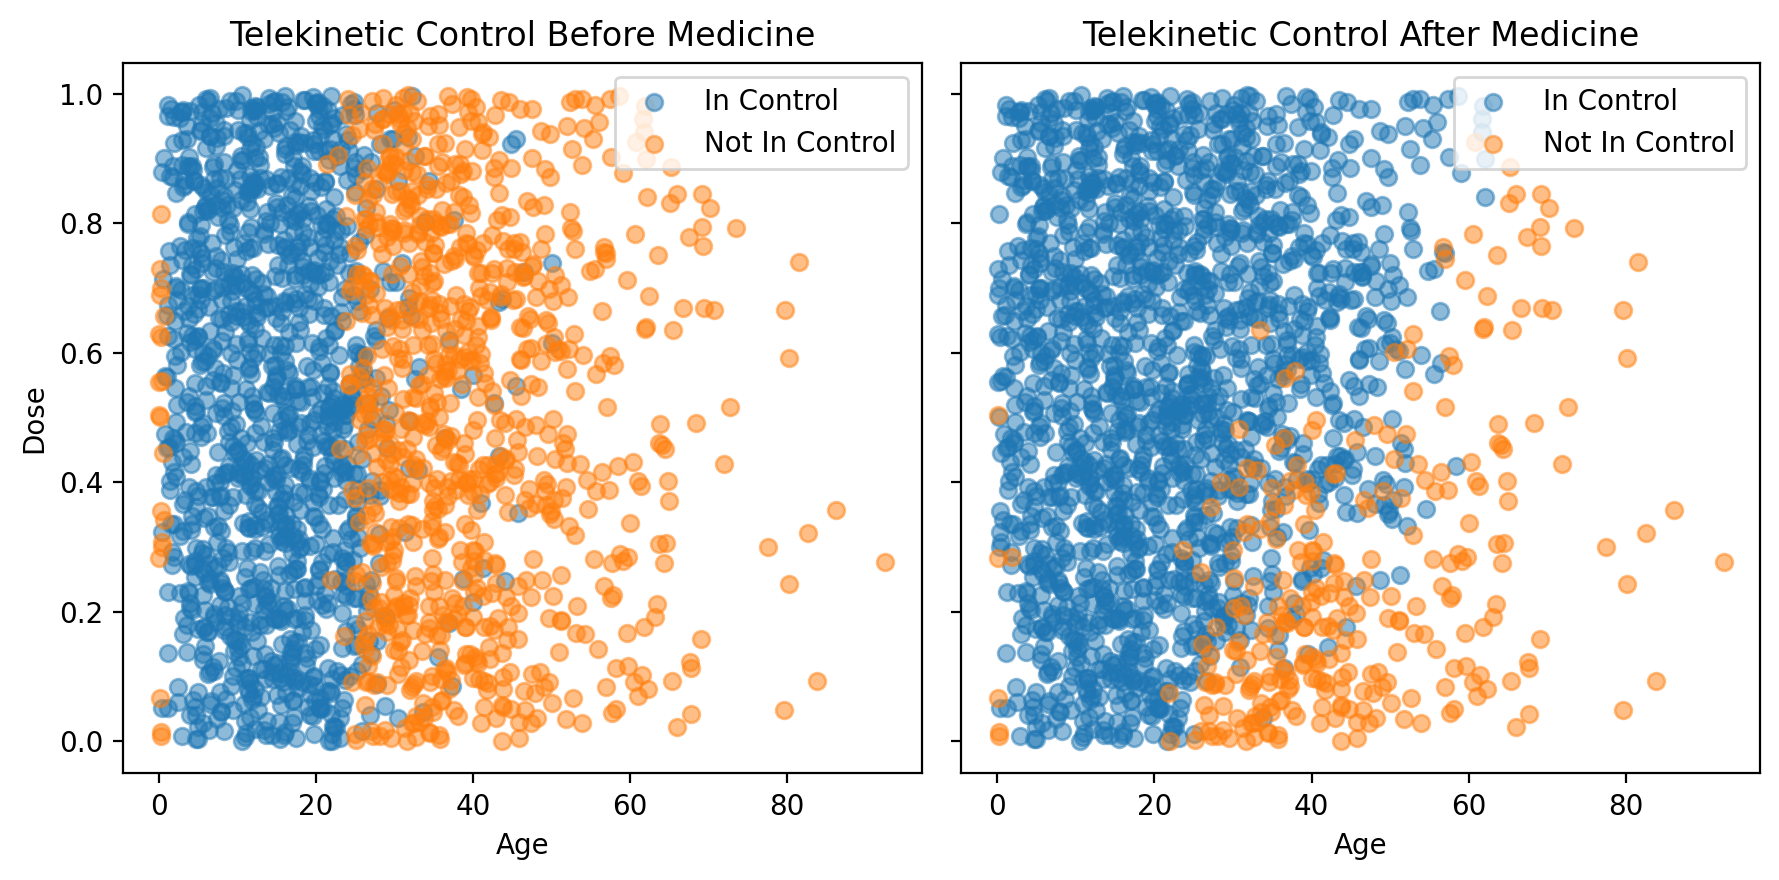

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5), sharex=True, sharey=True)

in_control = (data['Control-Before'] == 1)
axes[0].scatter(data['Age'][in_control], data['Dose'][in_control], alpha=0.5, label='In Control')
axes[0].scatter(data['Age'][~in_control], data['Dose'][~in_control], alpha=0.5, label='Not In Control')

axes[0].set_xlabel('Age')
axes[0].set_ylabel('Dose')
axes[0].set_title('Telekinetic Control Before Medicine')
axes[0].legend()

in_control = (data['Control-After'] == 1)
axes[1].scatter(data['Age'][in_control], data['Dose'][in_control], alpha=0.5, label='In Control')
axes[1].scatter(data['Age'][~in_control], data['Dose'][~in_control], alpha=0.5, label='Not In Control')

axes[1].set_xlabel('Age')
axes[1].set_title('Telekinetic Control After Medicine')
axes[1].legend()

plt.tight_layout()
plt.show()

Looking at the above plot, it seems like the medication has a positive affect---may of patients that seeked to regain their telekinetic control were able to regain it (i.e. many of the orange points became blue). Of course, the medication didn't help everyone. This is precisely why it is important to understand *who* the medication will help, and with *what* probability. 

## The Classification Model

**The Model.** Looking at our objective function, $\mathcal{L}(\theta)$, the only thing we need to define is $p_{Y | X}(y_n | x_n; \theta)$. Looking at the plot above, we see that $p_{Y | X}(y_n | x_n; \theta)$, should have the following form: for every point, $x_n$, it should assign a probability of being "in control." Therefore, our model should have two parts:
1. Some way of mapping $x_n$ to a probability between $0$ and $1$ (where $1$ indicates "in control").
2. Some way of sampling from this distribution.

To capture both components, we define our model as follows:
\begin{align}
p_{Y | X}(\cdot | x_n; \theta) = \mathrm{Ber}\left( \rho(x_n; \theta) \right),
\end{align}
where
\begin{align}
\rho(x_n; \theta) = \mathrm{sigmoid}\left( f(x_n; \theta) \right).
\end{align}
What does all of this mean? It means that our generative process is as follows:
1. We're given an input, $x_n$, from our data.
2. We feed it through our function $\rho(\cdot; \theta)$, which outputs the probability of telekinetic control. Here, $\theta$ controls the shape of this function. Because $\rho(\cdot; \theta)$ needs to output a probability, we need to ensure its output stays between $0$ and $1$. We do this as follows: we define a function $f(\cdot; \theta)$ that outputs real values, and then transform the output of this function into the range $[0, 1]$ using the sigmoid function. Check out its [Wikipedia page](https://en.wikipedia.org/wiki/Sigmoid_function) to see what it looks like. 
3. Finally, we sample from a Bernoulli with the probability given by $\rho(\cdot; \theta)$. This models the "noise" in the outcome; even for patients for which the medication is likely to work, the outcome is not guaranteed due to some unknown factors. 

**Expressivity.** Let's see what this looks like.

TODO diagrams.

As with linear vs. polynomial regression, the choice of $f(\cdot, \theta)$ determines the expressivity of the model. 

````{admonition} Exercise: Implement Linear Classification
**Part 1:** Using `NumPyro`, implement a linear classification model. Your model should only include the conditional distribution of outputs (telekinetic control *after* medication) given the inputs (age *and* dose); it should *not* include the marginal distribution of age and dose. Your model should therefore have the following signature:

```
def model_linear_classifier(N, age, dose, control=None):
    pass # TODO implement
```

Notice that here, we expect `age` and `dose` to *always* be passed in. This is because we're not looking to learn the distribution of these variables---we're always going to be given them.

Tips:
* Instead of writing your own sigmoid function, you can `import jax.nn as jnn` and then call `jnn.sigmoid` (you can find the documentation [here](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.sigmoid.html)). 
* Age spans a larger range than dose: age spans a range of roughly 0 to 100, whereas dose spans a range of roughly 0 to 1. Because of this disparity, gradient descent may find your optimization tricky. A learning rate that's appropriate for updating the coefficients of age may be too large for the dose and vice versa. Because of this, we recommend using the following functional form:
    \begin{align}
    f(\underbrace{a_n, d_n}_{x_n}; \underbrace{\theta_a, \theta_d, \theta_i}_{\theta}) &= \theta_a \cdot \frac{a_n}{100} + \theta_d \cdot d_n + \theta_i,
    \end{align}
    where $a_n$ is age with slope $\theta_a$, $d_n$ is dose with slope $\theta_d$, and $\theta_i$ is the intercept. Notice that we divide $a_n$ by $100$ to account for this difference in range.

**Part 2:** Fit the model to the data using the MLE. Plot the loss and verify that your optimization converged. In your plot you may want to zoom in on the last iterations of optimizations to verify it indeed converged. 

**Part 3:** Visualize your model fit by plotting samples from your model against the real data. 
* How well does your model fit the data? 
* For what patients will it perform well, and for which patients will it perform badly?
* For which patients is your model most uncertain about regarding the effect of the medication?
````

````{admonition} Exercise: Implement Non-Linear Classification
**Part 1:** Using `NumPyro`, implement a non-linear classifier---a classifier in which $f(\cdot; \theta)$ is not linear. Your choice of $f(\cdot; \theta)$ should:
* Make use of *at least* one parameter that will be learned from the data.
* Should fit the data better than the linear classifier from the previous exercise.

Please use the function signature below and follow the same tips.

```
def model_nonlinear_classifier(N, age, dose, control=None):
    pass # TODO implement
```

**Part 2:** Fit the model to the data using the MLE. Plot the loss and verify that your optimization converged. 

**Part 3:** Answer the following questions.
* How well does your model fit the data? 
* How did you pick $f(\cdot; \theta)$?
* For which patients is your model most uncertain about regarding the effect of the medication?
````

**TODOs:**
* Example plots of linear and non-linear classifiers
* Function for plotting classification boundaries